# Regularized Linear Regression and Bias vs Variance

In the first half of the example, we will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

NOTE: The example and sample data is being taken from the "Machine Learning course by Andrew Ng" in Coursera.

In [1]:
# initial imports
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
import seaborn as sns

In [2]:
# imports from my models designed for these examples
from models.linear_regression import compute_cost, gradient_descent, compute_gradient, train_linear_reg, validation_curve
from models.data_preprocessing import add_bias_unit, map_feature, feature_normalize

## Loading and Visualizing Data

We start the exercise by first loading and visualizing the dataset. 
The following code will load the dataset into your environment and plot the data.

We will begin by visualizing the dataset containing historical records on the
change in the water level, x, and the amount of water flowing out of the dam,
y.

This dataset is divided into three parts:  
<li>A training set that your model will learn on: X, y
<li>A cross validation set for determining the regularization parameter: Xval, yval
<li>A test set for evaluating performance. These are “unseen” examples which your model did not see during training: Xtest, ytest.


In the following parts, we will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, we will implement polynomial regression to find a better fit to the data.

In [3]:
# loading dataset
print("Loading & Visualizing Data")
import scipy.io as sio  # sio for loading matlab file .mat
data = sio.loadmat('data/ex5data1.mat')  # it geneates a dictionary of arrays found in the mat file
X = data['X']  # (12, 1)
y = data['y'][:, 0]  # (12,)
X_val = data['Xval']  # (21, 1)
y_val = data['yval'][:, 0]  # (21,)
X_test = data['Xtest']  # (21, 1)
y_test = data['ytest'][:, 0]  # (21,)
print(X_test.shape)

Loading & Visualizing Data
(21, 1)


Plotting training data


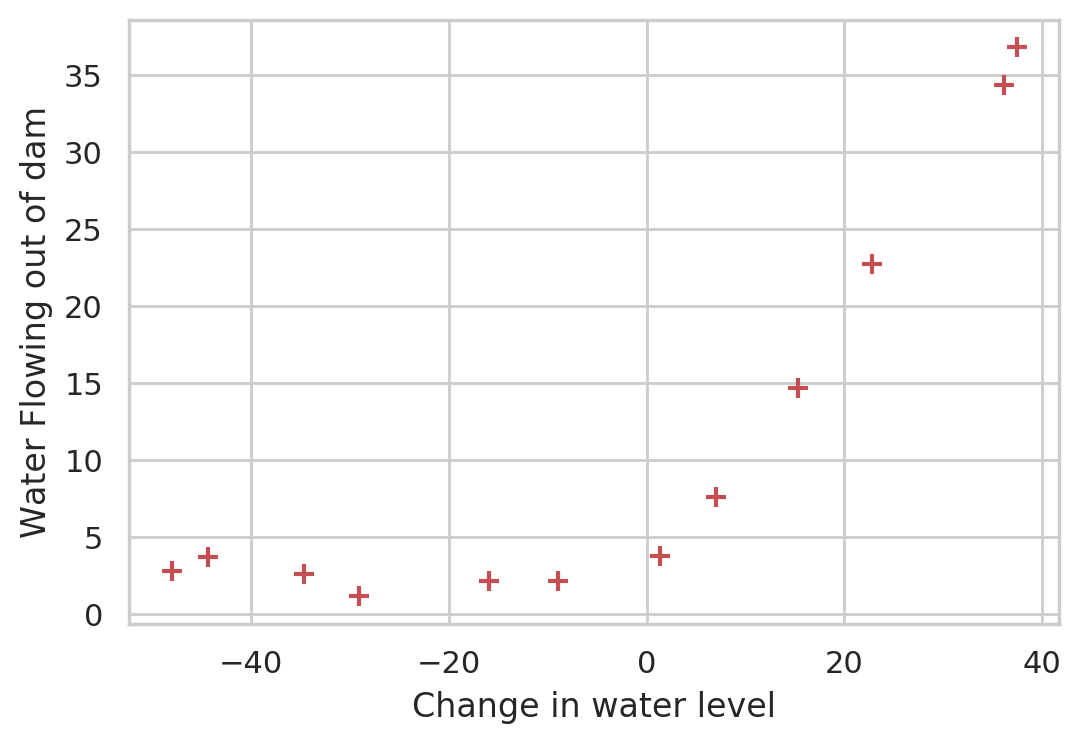

In [4]:
m = X.shape[0]  # number of examples = 12
print("Plotting training data")
plt.rcParams['figure.dpi'] = 200  # setting figure dpi for better quality graphs
sns.set(context="notebook", style="whitegrid")  # graph styling using seaborn

# the following lines generate a figure with 1 subplot
fig, ax = plt.subplots()
ax.scatter(X, y, marker='+', color='r', s=50);
ax.set_xlabel("Change in water level");
ax.set_ylabel('Water Flowing out of dam');

### Regualrized linear regression cost and gradient testing

The regularized linear regression has the following cost function:

\begin{equation}J(\theta)=\frac{1}{2 m}\left(\sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right)^{2}\right) + \frac{\lambda}{2 m}\left(\sum_{j=1}^{n} \theta_{j}^{2}\right)\end{equation}

where λ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a
penalty on the overal cost J. As the magnitudes of the model parameters $\theta_{j}$
increase, the penalty increases as well. Note that you should not regularize
the $\theta_{0}$ term.

Correspondingly, the partial derivative of regularized linear regression’s cost
for $\theta_{j}$ is defined as:

\begin{align*}
& \frac{\delta J(\theta)}{\delta\theta_{0}} = \frac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right)x^{(i)}_{j} & \text{for j}&=0 \\
& \frac{\delta J(\theta)}{\delta\theta_{j}} = \left(\frac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right)x^{(i)}_{j}\right) + \frac{\lambda}{m}\theta_{j} & \text{for j}&>=1
\end{align*}


Now we are testing the cost and gradient function in the models.linear_regression file

In [5]:
# initializing testing parameters
theta_test = np.array([1,1])
J = compute_cost(add_bias_unit(X), y, theta_test, lamda=1)
grad = compute_gradient(add_bias_unit(X), y, theta_test, lamda=1)
print("Cost at theta [1,1] is {}\n(this value should be 303.993192)".format(J))
print("Gradient at theta [1,1] is {}\n(this value should be [-15.303016, 598.250744])".format(grad.flatten()))


Cost at theta [1,1] is [303.99319222]
(this value should be 303.993192)
Gradient at theta [1,1] is [-15.30301567 598.25074417]
(this value should be [-15.303016, 598.250744])


## Training Linear Regression

For training the linear regression model we are going to define a function which is going to use scipy.optimize.minimize function to find the optimum theta or weights according to the given data.

In this part, we set regularization parameter λ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional θ, regularization will not be incredibly helpful for a θ of such low dimension. In the later parts of the example, we will be using polynomial regression with regularization.

In [6]:
# adding bias unit to X
bias_added_X = add_bias_unit(X)

# res will point to the result object generated by scipy minimize function.
# cst is the list of thetas after each iteration
res, cst = train_linear_reg(bias_added_X, y, 0)

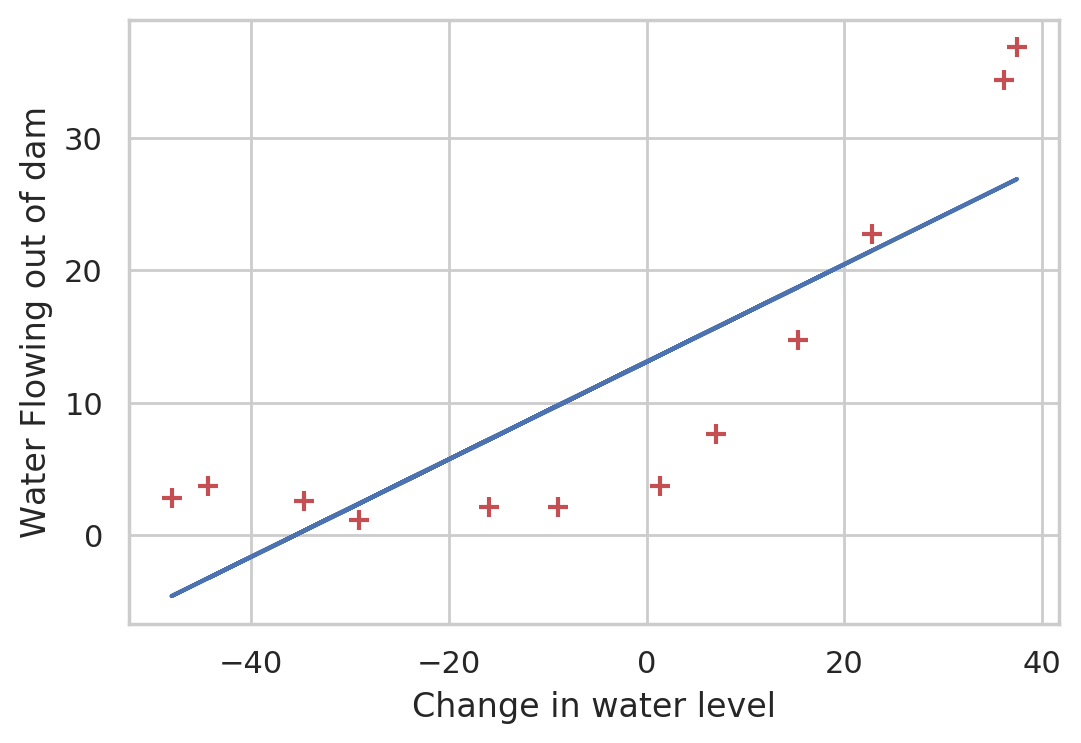

In [7]:
#plotting the data and curve trained by model
fig1, ax1 = plt.subplots()
ax1.scatter(X, y, marker='+', color='r', s=50);
ax1.set_xlabel("Change in water level")
ax1.set_ylabel('Water Flowing out of dam')
ax1.plot(X, bias_added_X@res.x);  # plotting best fit line

The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the data.

## Bias-variance

    An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

### Learning Curves

We will now implement code to generate the learning curves that will be useful in debugging learning algorithms. **A learning curve plots training and cross validation error as a function of training set size.**  

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, we will use different subsets of the original training set X. Specifically, for a training set size of i, we will use the first i examples (i.e., X(1:i,:) and y(1:i)).  
You can use the train_linear_reg function to find the θ parameters.  

After learning the θ parameters, we will compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

\begin{equation}
J_{train}(\theta) = \frac{1}{2m}\left[\sum_{i=1}^{m}\left( h_{\theta}\left( x^{(i)} \right) - y^{(i)} \right)^{2} \right]
\end{equation}

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set λ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., X(1:n,:) and y(1:n)) (instead of the entire training set). However, for the cross validation error, you should compute it over the entire cross validation set. You should store the computed errors in the vectors error train and error val.

In [8]:
print("Plotting Learning Curves")

lamda = 0
error_train = []
error_val = []
bias_added_X_val = add_bias_unit(X_val)

# computing training and cross validation error using training examples    
for i in range(1,m+1):
    print()
    print("processing dataset from 0 to {}".format(i))
    
    # training the model
    temp_result, _ = train_linear_reg(bias_added_X[0:i, :], y[0:i], lamda)
    temp_theta = temp_result.x
    
    print("temp_theta is {}".format(temp_theta))
    
    # storing errors in list
    error_train.append(compute_cost(bias_added_X[0:i, :], y[0:i], temp_theta, lamda))
    error_val.append(compute_cost(bias_added_X_val, y_val, temp_theta, lamda))
    
    print("processing complete!!")


Plotting Learning Curves

processing dataset from 0 to 1
temp_theta is [ 0.00837049 -0.13339852]
processing complete!!

processing dataset from 0 to 2
temp_theta is [3.29303644 0.07271423]
processing complete!!

processing dataset from 0 to 3
temp_theta is [14.15499007  0.53912266]
processing complete!!

processing dataset from 0 to 4
temp_theta is [14.62429855  0.55985727]
processing complete!!

processing dataset from 0 to 5
temp_theta is [17.21375974  0.44974975]
processing complete!!

processing dataset from 0 to 6
temp_theta is [15.40485112  0.45741711]
processing complete!!

processing dataset from 0 to 7
temp_theta is [14.26678005  0.4368173 ]
processing complete!!

processing dataset from 0 to 8
temp_theta is [14.62343987  0.42312838]
processing complete!!

processing dataset from 0 to 9
temp_theta is [13.29660996  0.41299409]
processing complete!!

processing dataset from 0 to 10
temp_theta is [13.85366299  0.37780979]
processing complete!!

processing dataset from 0 to 11
tem

Generating Learning curve


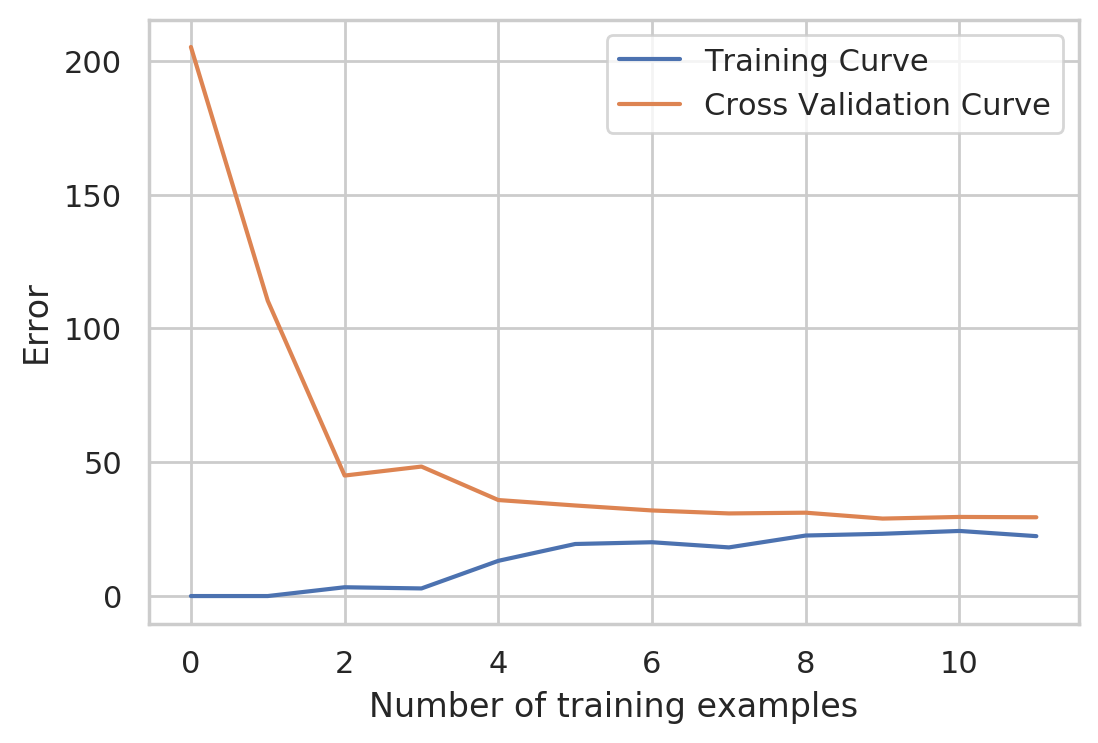

In [9]:
print("Generating Learning curve")
plt.plot(np.arange(m), error_train, label="Training Curve")
plt.plot(np.arange(m), error_val, label="Cross Validation Curve")
plt.xlabel("Number of training examples")
plt.ylabel('Error')
plt.legend()

In above Figure, you can observe that both the train error and cross validation
error are high when the number of training examples is increased. This reflects a high bias problem in the model – the linear regression model is too simple and is unable to fit our dataset well. In the next section, we will implement polynomial regression to fit a better model for this dataset.
## Polynomial Regression
The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will
address this problem by adding more features.
    For use polynomial regression, our hypothesis has the form:
   
\begin{align*} h_{\theta}(x) & = \theta_{0} + \theta_{1} * (waterLevel) + \theta_{2} *(waterLevel)^{2} + ... + \theta_{p} * (waterLevel)^{p} \\
& = \theta_{0} + \theta_{1}x_{2} + \dots + \theta_{p}x_{p}
\end{align*}

Notice that by defining $x_{1} = (waterLevel), x_{2} = (waterLevel)^{2}, \dots , x_{p} = (waterLevel)^{p}$, we obtain a linear regression model where the features are the
various powers of the original value $(\text{waterLevel})$.   
Now, you will add more features using the higher powers of the existing feature x in the dataset. NOw we are going to define a map_feature function, so that the function maps the original training set X of size $m × 1$ into its higher powers. Specifically, when a training set X of size $m × 1$ is passed into the function, the function should return a $m×p$ matrix $X poly$,where column 1 holds the original values of $X$, column 2 holds the values of $X^{2}$, column 3 holds the values of $X^{3}$, and so on. Note that you don’t have to account for the zero-eth power in this function.

In [10]:
max_degree = 8  # maximum degree upto which the polynomial terms are to be formed
# mapping X to polynomial features with degree upto 8
X_poly = map_feature(X, degree=max_degree, bias_unit=False)

# since the values of X_poly vary too much we are normalizing them
# mu is the mean values of individual features
# sigma is the standard daviation of individual features
X_poly, mu, sigma = feature_normalize(X_poly)

# adding bias unit to the polymerised data
X_poly = add_bias_unit(X_poly)

# mapping and normalizing the test dataset with the mu and sigma
X_poly_test = map_feature(X_test, degree=max_degree, bias_unit=False)
X_poly_test, _, __ = feature_normalize(X_poly_test, mean=mu, sigma=sigma)
X_poly_test = add_bias_unit(X_poly_test)

# mapping and normalizing the cross validation dataset with the mu and sigma
X_poly_val = map_feature(X_val, degree=max_degree, bias_unit=False)
X_poly_val, _, __ = feature_normalize(X_poly_val, mean=mu, sigma=sigma)
X_poly_val = add_bias_unit(X_poly_val)


print("First 5 Normalized training examples: ")
with np.printoptions(precision=8, suppress=True, linewidth=150):
    print(X_poly[:5, :])

First 5 Normalized training examples: 
[[ 1.         -0.3782437  -0.78866232  0.19032872 -0.7375913   0.32025197 -0.6171516   0.35983501 -0.53109126]
 [ 1.         -0.8389201   0.0013142  -0.25896174 -0.34156482  0.09754927 -0.45519664  0.26677343 -0.46887381]
 [ 1.          1.43871736  0.61083158  1.30534069  0.25622     1.02186338 -0.01269621  0.79021001 -0.17792698]
 [ 1.          1.4841233   0.73806846  1.4203124   0.41312183  1.1553483   0.13122371  0.91070022 -0.06228954]
 [ 1.         -1.49791929  1.93643966 -2.12774745  2.43510061 -2.51876748  2.71792174 -2.7633169   2.88908182]]


## Training using Polynomial Regression

In this section we are going to train the model using the new features(i.e. X_poly) generated by map_features function.  

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that we used for the earlier part of this exercise.  

For this part of the exercise, we will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with x = 40 will now have a feature x8 = 408 = 6.5 × 1012). Therefore, we used feature normalization in above section.  


In [11]:
lamda = 0

result_poly, cost_lst_poly = train_linear_reg(X_poly, y, lamda)
print("Training of polynomial regressor completed")
print("Training Cost: {}".format(result_poly.fun))

Training of polynomial regressor completed
Training Cost: [0.03193852]


Text(0.5, 1.0, 'Polynomial Fit, λ = 0')

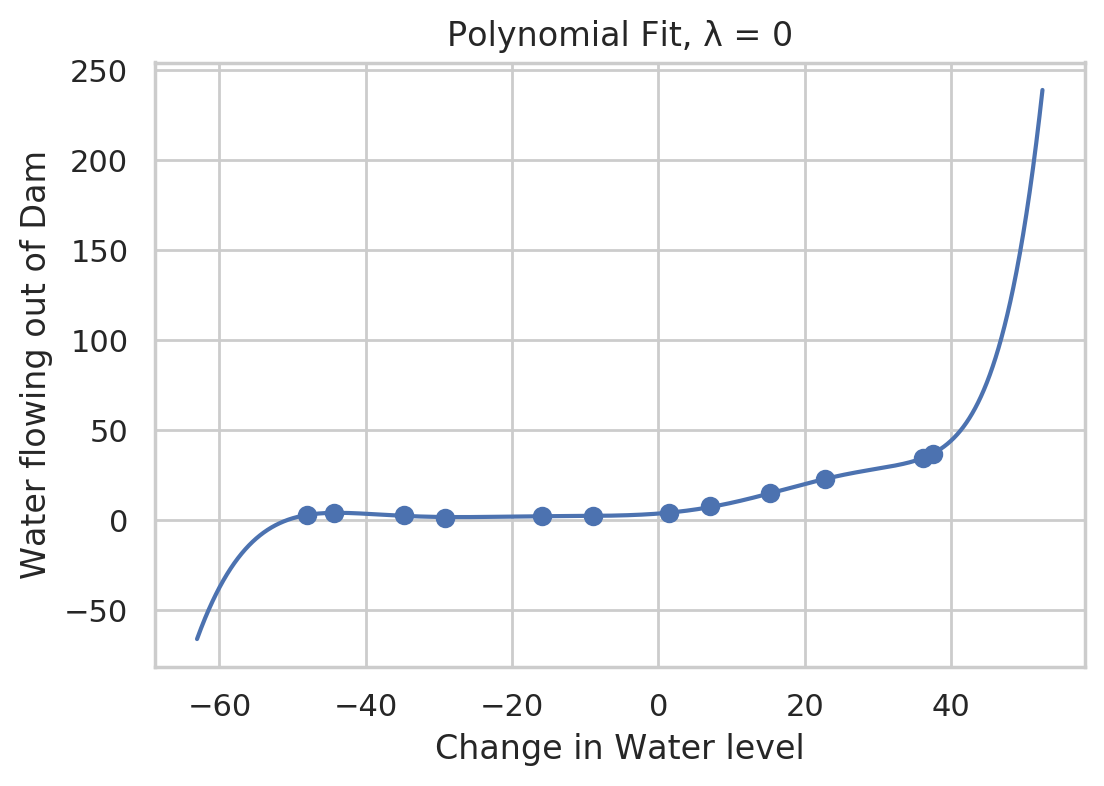

In [12]:
plt.scatter(X, y)

# generating an array containing X_intercepts
X_intercepts = np.arange(X.min()-15, X.max()+15, 0.05).reshape([-1,1])

# mapping the X-intercepts to max 8 degree
X_intercepts_poly = map_feature(X_intercepts, 8, bias_unit=False)
X_intercepts_poly, _, __ = feature_normalize(X_intercepts_poly, mean=mu, sigma=sigma)
X_intercepts_poly = add_bias_unit(X_intercepts_poly)

# plotting the curve using the thetas found by polynomial data
plt.plot(X_intercepts, X_intercepts_poly@result_poly.x)
plt.ylabel("Water flowing out of Dam")
plt.xlabel("Change in Water level")
plt.title("Polynomial Fit, λ = 0")

After learning the parameters $\theta_{polynomial}$, from above Figure, you could see that the polynomial fit is able to follow the datapoints very well - thus, obtaining a low training error. However, the polynomial fit is very complex and even drops off at the extremes. This is
an indicator that the polynomial regression model is overfitting the training
data and will not generalize well.

## Learning Curve for Polynomial Regression
    To better understand the problems with the unregularized (λ = 0) model, we are going to plot learning curve for the new model.

In [13]:
print("Computing Training and Cross Validation Error\n")
lamda = 0
error_train_poly = []
error_val_poly = []

print("Training Data size\tTrain cost\tCross Validation Cost")
# computing training and cross validation error using training examples    
for i in range(1,m+1):    
    # training the model
    temp_result_poly, _ = train_linear_reg(X_poly[0:i, :], y[0:i], lamda)
    temp_theta_poly = temp_result_poly.x
    
    # storing errors in list
    error_train_poly.append(compute_cost(X_poly[0:i, :], y[0:i], temp_theta_poly, lamda))
    error_val_poly.append(compute_cost(X_poly_val, y_val, temp_theta_poly, lamda))
    
    print("\t{}\t\t{:0.6f}\t{:0.6f}".format(i, error_train_poly[-1][0], error_val_poly[-1][0]))
    
print("processing complete!!")

Computing Training and Cross Validation Error

Training Data size	Train cost	Cross Validation Cost
	1		0.000000	161.442168
	2		0.000000	160.792292
	3		0.000000	68.190945
	4		0.000000	84.863965
	5		0.000000	6.486683
	6		0.000000	10.782185
	7		0.000000	27.972688
	8		0.000004	20.371517
	9		0.009334	29.825986
	10		0.039082	20.788307
	11		0.041092	16.836138
	12		0.031939	45.501432
processing complete!!


Plotting Learning curve with above generated data


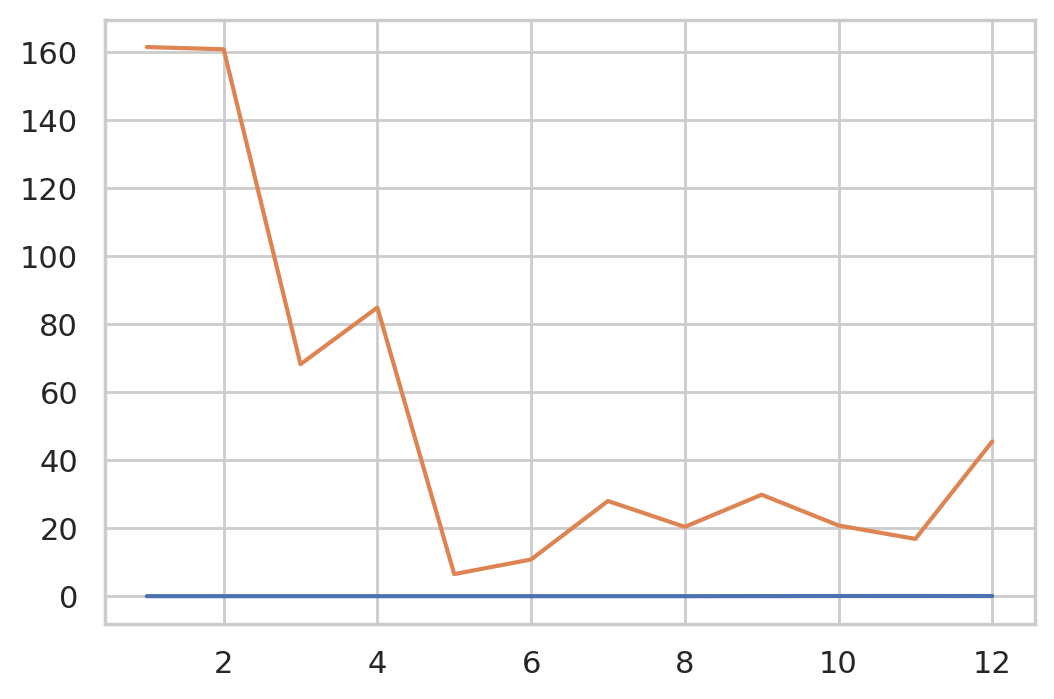

In [14]:
print("Plotting Learning curve with above generated data")

plt.plot(np.arange(1,m+1), error_train_poly)
plt.plot(np.arange(1,m+1), error_val_poly)

    You can see that the learning curve (Figure 5) shows the same effect where the low training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

## Adjusting the regularization parameter

In this section, we will observe how the regularization parameter affects the bias-variance of regularized polynomial regression.  

We are now going to modify the lambda paramter(λ) and try λ = 1, 100. For
each of these values, the script should generate a polynomial fit to the data
and also a learning curve.  

For λ = 1, you should see a polynomial fit that follows the data trend
well and a learning curve showing that both the cross
validation and training error converge to a relatively low value. This shows
the λ = 1 regularized polynomial regression model does not have the highbias or high-variance problems. In effect, it achieves a good trade-off between
bias and variance.  
For λ = 100, you should see a polynomial fit that does not
follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

### Lambda λ = 1

In [50]:
lamda = 1

result_poly_1, cost_lst_poly_1 = train_linear_reg(X_poly, y, lamda)
print("Training of polynomial regressor completed (λ = 1)")
print("Training Cost: {}".format(result_poly_1.fun))

Training of polynomial regressor completed (λ = 1)
Training Cost: [6.83046332]


Text(0.5, 1.0, 'Polynomial Fit, λ = 1')

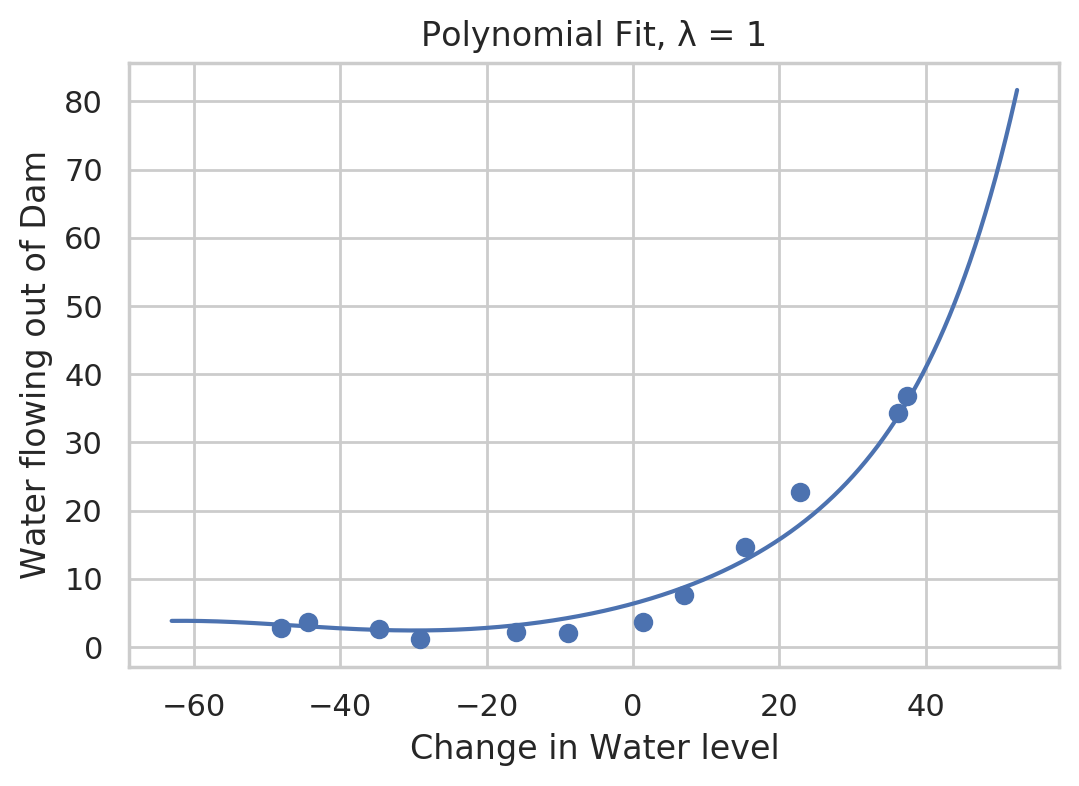

In [51]:
plt.scatter(X, y)

# generating an array containing X_intercepts
X_intercepts = np.arange(X.min()-15, X.max()+15, 0.05).reshape([-1,1])

# mapping the X-intercepts to max 8 degree
X_intercepts_poly = map_feature(X_intercepts, 8, bias_unit=False)
X_intercepts_poly, _, __ = feature_normalize(X_intercepts_poly, mean=mu, sigma=sigma)
X_intercepts_poly = add_bias_unit(X_intercepts_poly)

# plotting the curve using the thetas found by polynomial data
plt.plot(X_intercepts, X_intercepts_poly@result_poly_1.x)
plt.ylabel("Water flowing out of Dam")
plt.xlabel("Change in Water level")
plt.title("Polynomial Fit, λ = 1")

In [52]:
print("Computing Training and Cross Validation Error (λ = 1)\n")
lamda = 1
error_train_poly = []
error_val_poly = []

print("Training Data size\tTrain cost\tCross Validation Cost")
# computing training and cross validation error using training examples    
for i in range(1,m+1):    
    # training the model
    temp_result_poly, _ = train_linear_reg(X_poly[0:i, :], y[0:i], lamda)
    temp_theta_poly = temp_result_poly.x
    
    # storing errors in list
    error_train_poly.append(compute_cost(X_poly[0:i, :], y[0:i], temp_theta_poly, lamda))
    error_val_poly.append(compute_cost(X_poly_val, y_val, temp_theta_poly, lamda))
    
    print("\t{}\t\t{:0.6f}\t{:0.6f}".format(i, error_train_poly[-1][0], error_val_poly[-1][0]))
    
print("processing complete!!")

Computing Training and Cross Validation Error (λ = 1)

Training Data size	Train cost	Cross Validation Cost
	1		0.000000	138.846776
	2		0.070327	143.505063
	3		17.182727	7.845035
	4		13.476899	9.212261
	5		10.781524	9.222846
	6		9.347014	11.024707
	7		8.754387	8.290400
	8		7.682189	8.001082
	9		7.277291	8.793858
	10		6.592031	8.528102
	11		5.994056	8.585953
	12		6.830463	7.047218
processing complete!!


Plotting Learning curve with above generated data


Text(0.5, 1.0, 'Learning Curve (λ = 1)')

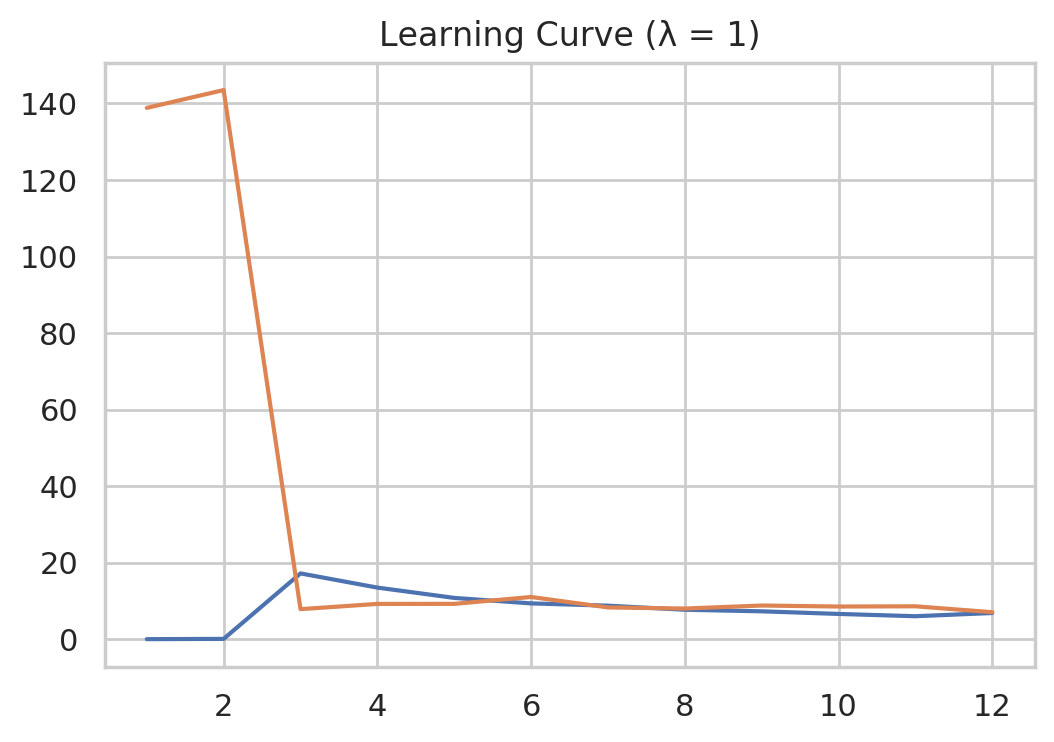

In [55]:
print("Plotting Learning curve with above generated data")

plt.plot(np.arange(1,m+1), error_train_poly)
plt.plot(np.arange(1,m+1), error_val_poly)
plt.title("Learning Curve (λ = 1)")

### Lambda λ = 100

In [19]:
lamda = 100

result_poly_100, cost_lst_poly_100 = train_linear_reg(X_poly, y, lamda)
print("Training of polynomial regressor completed (λ = 100)")
print("Training Cost: {}".format(result_poly_100.fun))

Training of polynomial regressor completed (λ = 100)
Training Cost: [65.95095506]


Text(0.5, 1.0, 'Polynomial Fit, λ = 100')

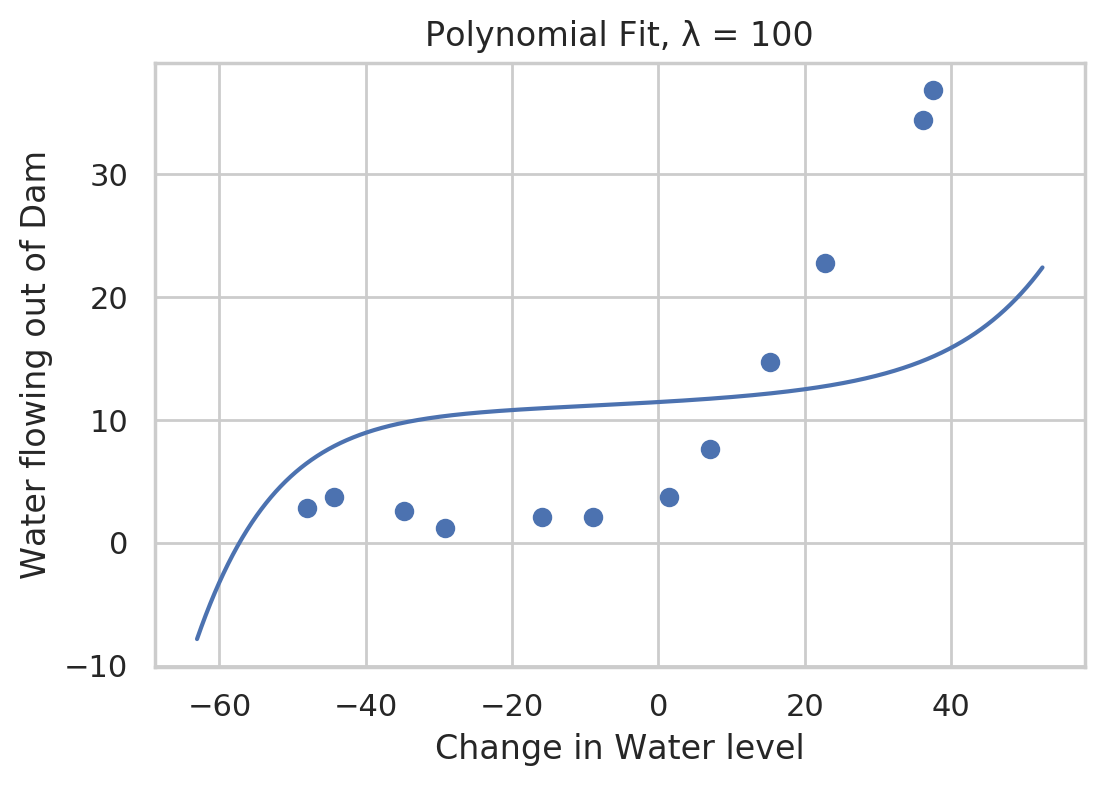

In [20]:
plt.scatter(X, y)

# generating an array containing X_intercepts
X_intercepts = np.arange(X.min()-15, X.max()+15, 0.05).reshape([-1,1])

# mapping the X-intercepts to max 8 degree
X_intercepts_poly = map_feature(X_intercepts, 8, bias_unit=False)
X_intercepts_poly, _, __ = feature_normalize(X_intercepts_poly, mean=mu, sigma=sigma)
X_intercepts_poly = add_bias_unit(X_intercepts_poly)

# plotting the curve using the thetas found by polynomial data
plt.plot(X_intercepts, X_intercepts_poly@result_poly_100.x)
plt.ylabel("Water flowing out of Dam")
plt.xlabel("Change in Water level")
plt.title("Polynomial Fit, λ = 100")

In [21]:
print("Computing Training and Cross Validation Error (λ = 1)\n")
lamda = 100
error_train_poly = []
error_val_poly = []

print("Training Data size\tTrain cost\tCross Validation Cost")
# computing training and cross validation error using training examples    
for i in range(1,m+1):    
    # training the model
    temp_result_poly, _ = train_linear_reg(X_poly[0:i, :], y[0:i], lamda)
    temp_theta_poly = temp_result_poly.x
    
    # storing errors in list
    error_train_poly.append(compute_cost(X_poly[0:i, :], y[0:i], temp_theta_poly, lamda))
    error_val_poly.append(compute_cost(X_poly_val, y_val, temp_theta_poly, lamda))
    
    print("\t{}\t\t{:0.6f}\t{:0.6f}".format(i, error_train_poly[-1][0], error_val_poly[-1][0]))
    
print("processing complete!!")

Computing Training and Cross Validation Error (λ = 1)

Training Data size	Train cost	Cross Validation Cost
	1		0.000000	138.846777
	2		0.114717	144.124099
	3		112.255156	70.935873
	4		131.638608	79.137897
	5		116.062526	66.126942
	6		108.778507	61.957759
	7		93.297101	62.018723
	8		86.349367	61.581277
	9		80.206754	62.481408
	10		73.060272	62.979548
	11		66.883255	63.626911
	12		65.950955	61.559272
processing complete!!


Plotting Learning curve with above generated data


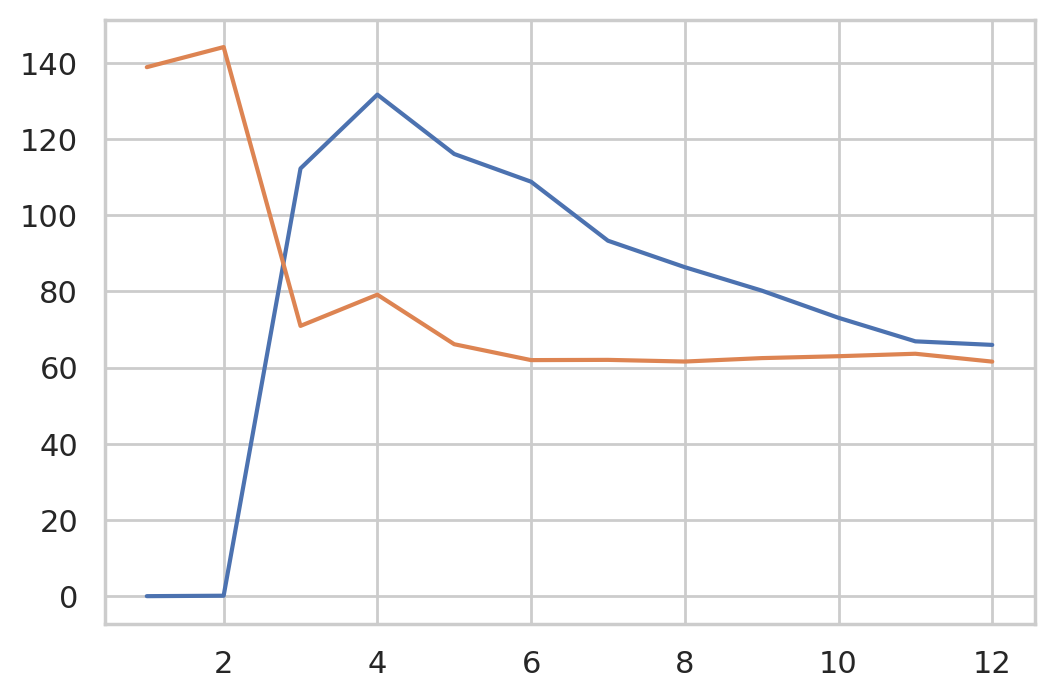

In [22]:
print("Plotting Learning curve with above generated data")

plt.plot(np.arange(1,m+1), error_train_poly)
plt.plot(np.arange(1,m+1), error_val_poly)

## Selecting λ using cross validation curve
From the previous parts of the exercise, we observed that the value of λ can significantly affect the results of regularized polynomial regression on the training and cross validation set.  

In particular, a model without regularization (λ = 0) fits the training set well, but does not generalize. Conversely,a model with too much regularization (λ = 100) does not fit the training set and testing set well. A good choice of λ (e.g., λ = 1) can provide a good fit to the data.  


In this section, we will implement training with different lambda values to select the λ parameter. Concretely, we will use a cross validation set to evaluate how good each λ value is. After selecting the best λ value using the cross validation set, we can then evaluate the model on the test set to estimate
how well the model will perform on actual unseen data.  


Specifically, we will use the train_linear_reg function to train the model using different values of λ and compute the training error and cross validation error.

**You should try λ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}**

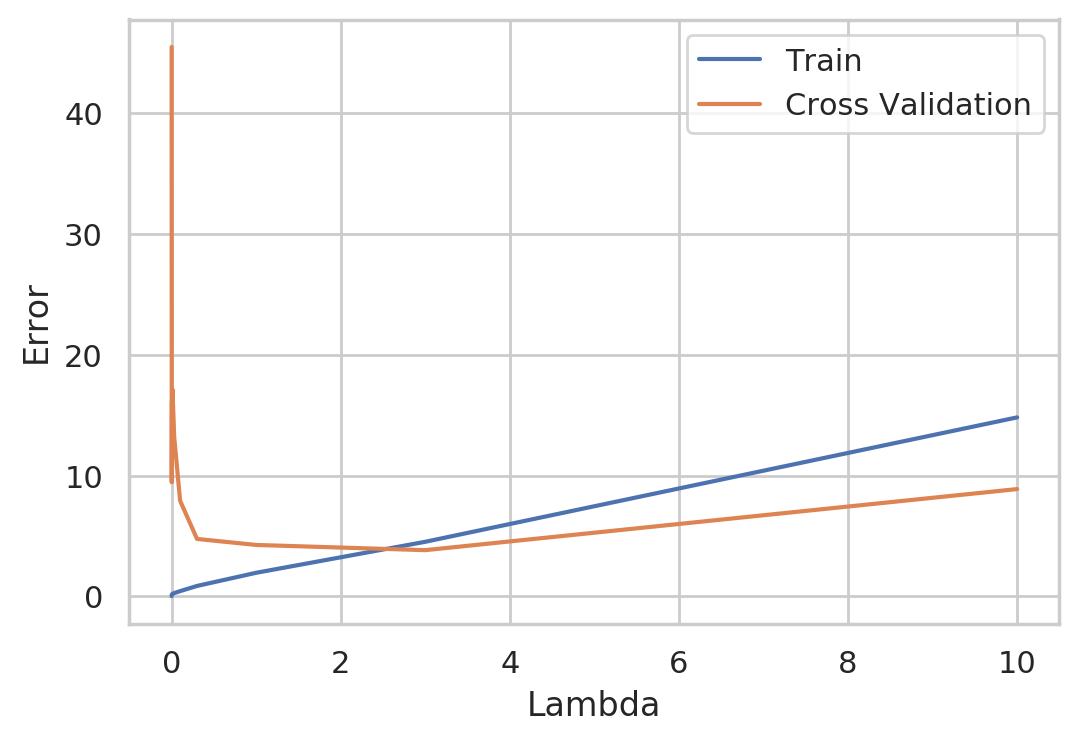

In [56]:
lambda_list = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

_, train_cost_lst, cv_cost_lst = validation_curve(X_poly, y, X_poly_val, y_val, lambda_list)

# train_cost_lst - training cost corresponding to lamda values
# cv_cost_lst - cross validation cost corresponding to lamda values

# plotting training cost and cross validation cost
plt.plot(np.array(lambda_list), train_cost_lst, label="Train")
plt.plot(np.array(lambda_list), cv_cost_lst, label="Cross Validation")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend()
#plt.xticks(np.arange(len(lambda_list)),lambda_list)

In this
figure, we can see that the best value of λ is around 3. Due to randomness
in the training and validation splits of the dataset, the cross validation error
can sometimes be lower than the training error.